### Classification Project - Predicting heart disease  This project uses Python based Machine Learning (ML) to build a **model capable of predicting heart disease** given medical data attributes. The data is sourced from the widely used UC Irvine Machine Learning Repository. The Python libraries used are from Scikit-learn, Pandas, NumPy, Matplotlib and Seaborn.<br>The end results will include a model that has been tuned, including feature importance, cross validation, metric reporting and visual representation.

![](images/6-step-ml-framework.png)

#### 1.  Problem definition
Given clinical parameters about a patient, can we predict whether or not they have heart disease?

#### 2.  Data 
The original data came from the Clevland data UCI Machine Learning Repository. https://archive.ics.uci.edu/ml/datasets/heart+Disease There is also a version of it available on Kaggle. https://www.kaggle.com/ronitf/heart-disease-uci

#### 3.  Evaluation
If we can reach `85% accuracy` predicting whether or not a patient has heart disease during the proof of concept, we'll pursue the project.

#### 4.  Features
This database contains 76 attributes, but all published experiments refer to using a subset of 14 of them.  Please refer to the data dictionary below:

![](images/attributes_hd_description.png)

#### 5.  Modeling: Tools used

In [1]:
# (EDA) Exploring Data Analysis and plotting libraries
import pandas as pd
import numpy as np
%matplotlib inline 
import matplotlib.pyplot as plt

import seaborn as sns

# Models from Scikit-Learn
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler

# Model Evaluations
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import RocCurveDisplay

#### Setting up the Machine Learning (ML) model

- Import the data set

In [2]:
dataframe = pd.read_csv("data/heart-disease.csv")   # Clevland data UCI Machine Learning Repository - Heart Disease
dataframe.head(1)

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1


#### Cleaning up the data to find patterns
* Address any missing values.
* Transformers for any non-numerical data.
* Find patterns and understand the data:
    - **Engage Subject Matter Experts (SME's)** to understand the data.
    - **Sanity check with SME's to verify finding (human input)**.
<div>
<img src="images/sme_collab.png" width="400">
</div>
<br>

#### Feature importantance (positive/negative correlation)
- Based on a trained ML models
- How important is each feature to the target (independent variable)
- Allows us to scrap un-important features
- Get more insight from SME's

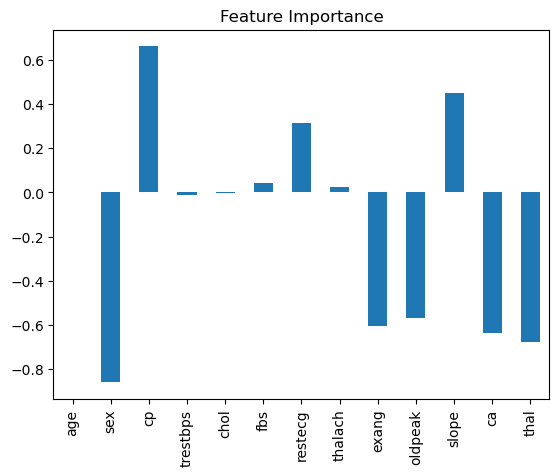

In [3]:
# Split data into X and y
X = dataframe.drop("target", axis=1)
y = dataframe["target"]

# Constant 
np.random.seed(42)

# Split into train & test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Fit an instance of LogisticRegression
clf = LogisticRegression(C=0.20433597178569418, solver="liblinear")
clf.fit(X_train, y_train);

# Check the coefficient(s) prior to running following code
clf.coef_

# Match coef's of features to columns
feature_dict = dict(zip(dataframe.columns, list(clf.coef_[0])))

# Visualize feature importance
feature_df = pd.DataFrame(feature_dict, index=[0])
feature_df.T.plot.bar(title="Feature Importance", legend=False);

#### Compare different ML models
- Trained on the same data
- Compared based on base modelperformance

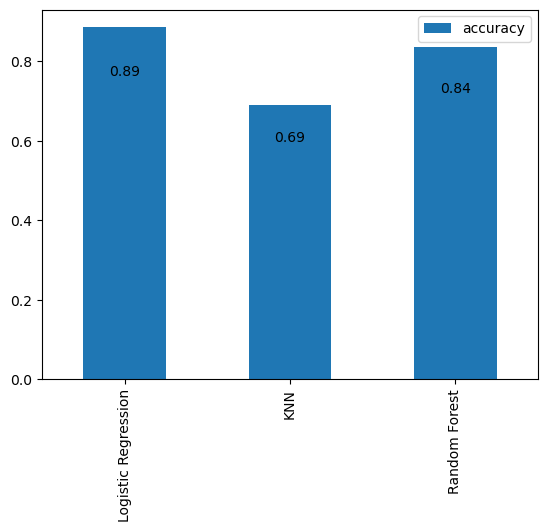

In [4]:
# Put models in a dictionary
models = {"Logistic Regression": LogisticRegression(max_iter=1000),
          "KNN": KNeighborsClassifier(),
          "Random Forest": RandomForestClassifier()}
l = []
# Create a function to fit and score models
def fit_and_score(models, X_train, X_test, y_train, y_test):
    """
    Fits and evaluates given machine learning models.
    models : a dict of differetn Scikit-Learn machine learning models
    X_train : training data (no labels)
    X_test : testing data (no labels)
    y_train : training labels
    y_test : test labels
    """
    # Set random seed
    np.random.seed(42)
    # Make a dictionary to keep model scores
    model_scores = {}

    for key, model in models.items():
        model.fit(X_train, y_train)
        model_scores[key] = model.score(X_test, y_test)
    return model_scores
    
model_scores = fit_and_score(models, X_train, X_test, y_train, y_test)
model_compare = pd.DataFrame(model_scores, index=["accuracy"])

ax = model_compare.T.plot(kind='bar') 

# Show accuracy scores on the bar graph
for p in ax.patches:
    ax.annotate(text=np.round(p.get_height(), decimals=2),
                xy=(p.get_x()+p.get_width()/2., p.get_height()/1.2),
                ha='center',
                va='center',
                xytext=(0, 10),
                textcoords='offset points')

### Compare performance across models
- **Logistic Regression : 88.5% accuracy**
- Random Forest': 83.6%
- (KNN) KNeighborsClassifier : 68.8%

#### Tune the hyperparameters 
- Score remains at 88.5% accuracy for Logistic Regression after using RandomizedSearchCV to tune the hyperparameters

In [5]:
# Tune the model using RandomizedSearchCV
logistical_regression_grid = {"C" : np.logspace(-4, 4, 20), "solver": ["liblinear"]}
np.random.seed(42)
rsCV_tuning = RandomizedSearchCV(LogisticRegression(), 
                                param_distributions = logistical_regression_grid,
                                cv=5,
                                n_iter=10,
                                verbose=True)
rsCV_tuning.fit(X_train, y_train)
# rsCV_tuning.best_params_
rsCV_tuning.score(X_test, y_test)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


0.8852459016393442

#### Cross-Validate the train and test scenarios
- Use 5 versions of training data
- Verify new test scores to verify consistantcy

In [6]:
metrics = ["accuracy", "precision", "recall", 'f1']
#'liblinear'
clf = LogisticRegression(C=0.20433597178569418, solver= 'liblinear', max_iter=1000)
cv_accuracy = cross_val_score(clf, X, y, 
                              scoring="accuracy")
# cv_accuracy.mean()
cv1 = np.mean(cv_accuracy)
cv_accuracy = round(cv1, 3)

# Cross-validated precision
cv_precision = cross_val_score(clf, X, y, cv=5,
                         scoring="precision")
cv2 = np.mean(cv_precision)
cv_precision= round(cv2, 2)

# Cross-validated recall
cv_recall = cross_val_score(clf, X, y,cv=5,
                         scoring="recall")
cv3 = np.mean(cv_recall)
cv_recall = round(cv3, 2)

# Cross-validated f1-score
cv_f1 = cross_val_score(clf, X, y, cv=5,
                         scoring="f1")
cv4 = np.mean(cv_f1)
cv_f1 = round(cv4, 2)

cv_metrics = pd.DataFrame({"Accuracy": cv_accuracy,
                           "Precision": cv_precision,
                           "Recall": cv_recall,
                           "F1": cv_f1},
                          index=[0])

#### Review Metrics after being cross-validated
- `Accuracy` (default) = The percentage (%) of total predictions you got right (predicted 1 or 0/actual 1 or 0)
    - TP + TN / TP + FP +TN + FN
- `Precision` = What % of the subset (positive 1) of your predictions were correct.  How  good is the model at predicting True positives
    - TP predicted HAS heart-disease/ TP + FP) 
- `Recall` = What % of actual (total positive 1).  How good is the model at predicting both (true positive and false negatives)
    - TP / (TP + FN)
- `F1` = Combined recall and precision
    -  Equal weights for both FP and FN Harmonic mean (Precision, recall)
    -  2 / recall recision

![](images/ConfusionMatrix.png)

In [7]:
cv_metrics

,Accuracy,Precision,Recall,F1
0,0.845,0.82,0.92,0.87


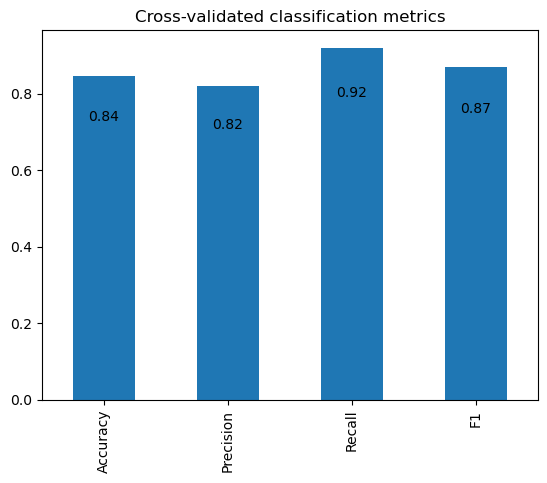

In [8]:
ax = cv_metrics.T.plot(kind='bar', title="Cross-validated classification metrics",
                      legend=False) 

# Show accuracy scores on the bar graph
# https://matplotlib.org/3.3.0/api/_as_gen/matplotlib.axes.Axes.annotate.html
for p in ax.patches:
    ax.annotate(text=np.round(p.get_height(), decimals=2),
                xy=(p.get_x()+p.get_width()/2., p.get_height()/1.2),
                ha='center',
                va='center',
                xytext=(0, 10),
                textcoords='offset points')

#### Summerizing the metric results
- It is really bad if the model is good at prediction only 1 of the 2 possible outcomes.  This is why it could be misleading to look at precission and recall in isolation.  When looking at the F1 score we see that when both (precision and recall) are looked at together it gives us a balanced view of how well the model predicts both together.

#### Considerations to acheive higher metric scores
* Get more data
* Consider other models to use like CatBoost or XGBoost
* Consider sharing your data with colleagues... Save and load directions below

In [9]:
# import pickle

# used to save the notebook in the current folder
#pickle.dump(clf, open("Logistic_Regression_model_1.pkl", 'wb'))

#used to load the model
# loaded_model = pickle.load(open("Logistic_Regression_model_1.pkl", 'rb'))
# loaded_model.score(X-test, y_test)